In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline
import pickle

### Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings

In [36]:
data = pd.read_csv("../data/preprocessed_data.csv", index_col= False)
data.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_rest_del_loc,hour,day,weekday_name,TypeOfMeal
0,30.0,4.7,conditions Sandstorms,Jam,0.0,Meal,motorcycle,1.0,No,Metropolitian,34.0,10.336614,19,20,Sunday,Dinner
1,30.0,4.7,conditions Sandstorms,Jam,0.0,Buffet,motorcycle,1.0,No,Metropolitian,46.0,5.849717,20,3,Sunday,Dinner
2,30.0,4.7,conditions Sunny,Low,0.0,Drinks,motorcycle,1.0,No,Metropolitian,19.0,0.974953,9,28,Monday,Breakfast
3,30.0,4.7,conditions Cloudy,Medium,1.0,Drinks,motorcycle,1.0,No,Metropolitian,42.0,7.799623,18,2,Wednesday,Dinner
4,30.0,4.7,conditions Windy,Jam,0.0,Snack,motorcycle,1.0,No,Metropolitian,44.0,10.724479,19,29,Tuesday,Dinner


In [3]:
data.dtypes

Delivery_person_Age        float64
Delivery_person_Ratings    float64
Weatherconditions           object
Road_traffic_density        object
Vehicle_condition          float64
Type_of_order               object
Type_of_vehicle             object
multiple_deliveries        float64
Festival                    object
City                        object
Time_taken(min)            float64
distance_rest_del_loc      float64
hour                         int64
day                          int64
weekday_name                object
TypeOfMeal                  object
dtype: object

In [4]:
### Features and Predictors(Target)
X = data.drop(['Time_taken(min)'], axis =1)
y = data['Time_taken(min)']

In [5]:
### Splitting the data into Train validation and test
X_train, X_test,y_train ,  y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_Val,  X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.33, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_Val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35089, 15) (35089,)
(5877, 15) (5877,)
(2896, 15) (2896,)


In [6]:
X_train.dtypes

Delivery_person_Age        float64
Delivery_person_Ratings    float64
Weatherconditions           object
Road_traffic_density        object
Vehicle_condition          float64
Type_of_order               object
Type_of_vehicle             object
multiple_deliveries        float64
Festival                    object
City                        object
distance_rest_del_loc      float64
hour                         int64
day                          int64
weekday_name                object
TypeOfMeal                  object
dtype: object

# Experiment

In [7]:
def convert_categorical_numerical_single(df, categorical_columns, fitted_encoder):
    # Transform using the pre-fitted encoder
    one_hot_encoded = fitted_encoder.transform(df[categorical_columns])
    one_hot_data = pd.DataFrame(one_hot_encoded, 
                                columns=fitted_encoder.get_feature_names_out(categorical_columns))
    
    df_rest_index = df.reset_index(drop=True, inplace=False)
    df_encoded = pd.concat([df_rest_index, one_hot_data], axis=1)
    df_encoded = df_encoded.drop(columns=categorical_columns, axis=1)
    return df_encoded

def feature_scaling_numeric_columns_single(df, numerical_columns, fitted_scaler):
    df[numerical_columns] = fitted_scaler.transform(df[numerical_columns])
    return df

def data_preprocessing(data, train=True, encoder = None, scaler = None):
    categorical_features = data.select_dtypes(include=['object']).columns
    if train == True:
        encoder = OneHotEncoder(sparse_output = False, handle_unknown='error')
        one_hot_encoded = encoder.fit_transform(data[categorical_features])
        one_hot_data = pd.DataFrame(one_hot_encoded, 
                                    columns = encoder.get_feature_names_out(categorical_features)) 
        df_rest_index = data.reset_index(drop = True, inplace = False)   
        df_encoded = pd.concat([df_rest_index, one_hot_data], axis =1)
        df_encoded = df_encoded.drop(columns = categorical_features, axis =1)

        numerical_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns
        scaler = StandardScaler()
        df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
        return df_encoded, encoder, scaler
    
    else:
        data_encoded = convert_categorical_numerical_single(data, categorical_features, encoder)
        numerical_features = data_encoded.select_dtypes(include=['float64', 'int64']).columns
        #print(numerical_features)
        data_scaled = feature_scaling_numeric_columns_single(data_encoded, numerical_features, scaler)
        return data_scaled
    

In [8]:
X_train_pre,encoder, scaler = data_preprocessing(X_train, train=True,encoder = None, scaler =None)
X_Val_pre = data_preprocessing(X_Val, train=False, encoder = encoder, scaler =scaler)
X_test_pre = data_preprocessing(X_test, train=False, encoder = encoder, scaler =scaler)

In [10]:
### Applying various ML models
def model_training(X_train, X_test, y_train, y_test, ml_model):
    # Train the model
    ml_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = ml_model.predict(X_train)
    y_pred_test = ml_model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

    print(f"Model: {ml_model.__class__.__name__}")
    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")

    print('-' * 50)

    return ml_model, test_mse, test_r2, test_rmse

## ML models

In [ ]:


# Suppress all warnings
warnings.filterwarnings("ignore")

models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42),
    LGBMRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model
trained_models = {}
for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_Val_pre, y_train, y_val, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'val_mse': test_mse, 'r2_score': r2, 'rmse': rmse}


for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_test_pre, y_train, y_test, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'test_mse': test_mse, 'r2_score': r2, 'rmse': rmse}



### LightGBM model is performing better than remaining models

In [11]:
import  lightgbm as lgb
hyper_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'feature_fraction': 0.9
}

In [12]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train_pre, y_train,
        eval_set=[(X_test_pre, y_test)],
        eval_metric='l1')

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              metric='rmse', objective='regression')

In [13]:

y_pred_test = gbm.predict(X_test_pre)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

print(f"Model: {gbm.__class__.__name__}")
print(f"Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Model: LGBMRegressor
Test MSE: 13.8444, R2 Score: 0.8373, RMSE: 3.7208


/Users/harshayarravarapu/Documents/GitHub/Est_food_delivery_time/eta/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
def GetMetrics(y, predictions):
    return {'MSE' : mean_squared_error(y, predictions),
            'RMSE' : np.sqrt(mean_squared_error(y, predictions)),
            'MAE': mean_absolute_error(y, predictions)}

In [15]:
### Getting predictions

from sklearn.metrics import explained_variance_score, max_error
Summary = pd.DataFrame(GetMetrics(y = y_test, predictions = y_pred_test), index = ['Score'])

Summary['Explained Variance'] = explained_variance_score(y_test, y_pred_test)
Summary['Max Error'] = max_error(y_test, y_pred_test)

In [16]:
Summary

,MSE,RMSE,MAE,Explained Variance,Max Error
Score,13.84443,3.72081,2.977898,0.837359,15.331913


In [17]:
predictions = y_pred_test

In [18]:
ComparationTable = pd.DataFrame({
    'Real Value' : y_test.values,
    'Model Prediction' : [round(item) for item in y_pred_test],
    'Difference' : y_test.values - [round(item) for item in y_pred_test],
    'Difference %' : np.absolute((y_test.values - [round(item) for item in y_pred_test]) / y_test.values * 100)})

ComparationTable.head()

,Real Value,Model Prediction,Difference,Difference %
0,21.0,22,-1.0,4.761905
1,21.0,25,-4.0,19.047619
2,11.0,17,-6.0,54.545455
3,17.0,17,0.0,0.000000
4,17.0,15,2.0,11.764706


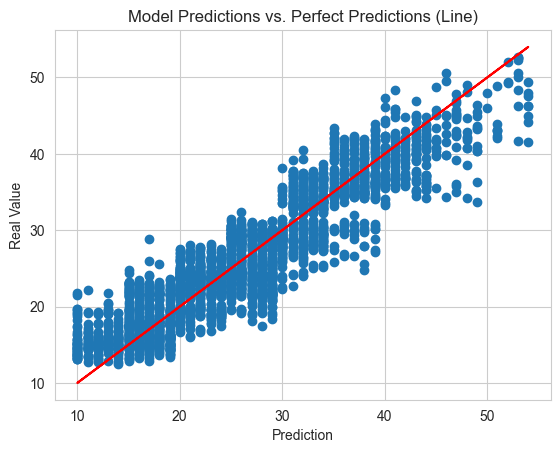

In [19]:
# Our predictions
plt.scatter(y_test, predictions)

# Perfect predictions
plt.plot(y_test, y_test, 'r')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.title('Model Predictions vs. Perfect Predictions (Line)');

/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_81636/1639379172.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(errors)


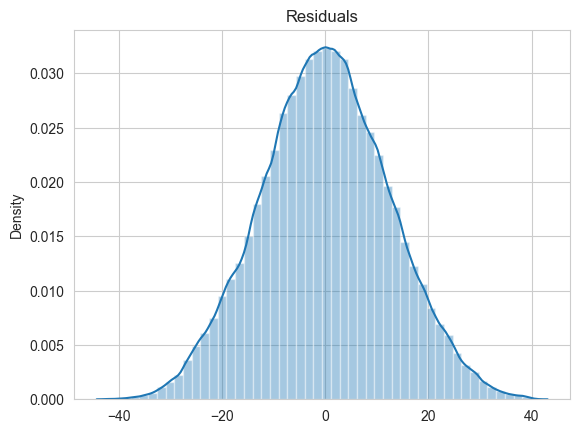

In [20]:
errors = y_test.values.reshape(-1, 1) - predictions
sns.distplot(errors)
plt.title('Residuals');

In [21]:
# Worst predictions
ComparationTable.sort_values(by = 'Difference %', ascending = False).head(10)

,Real Value,Model Prediction,Difference,Difference %
1110,10.0,22,-12.0,120.0
1851,10.0,22,-12.0,120.0
1146,10.0,20,-10.0,100.0
1520,10.0,20,-10.0,100.0
2182,11.0,22,-11.0,100.0
2884,10.0,19,-9.0,90.0
1174,10.0,19,-9.0,90.0
1737,10.0,19,-9.0,90.0
2893,10.0,19,-9.0,90.0
2545,10.0,18,-8.0,80.0


In [22]:
# Best predictions
ComparationTable.sort_values(by = 'Difference %', ascending = True).head(10)

,Real Value,Model Prediction,Difference,Difference %
2495,27.0,27,0.0,0.0
1300,13.0,13,0.0,0.0
1016,40.0,40,0.0,0.0
1013,20.0,20,0.0,0.0
1003,23.0,23,0.0,0.0
1002,16.0,16,0.0,0.0
1611,14.0,14,0.0,0.0
999,24.0,24,0.0,0.0
463,24.0,24,0.0,0.0
1308,16.0,16,0.0,0.0


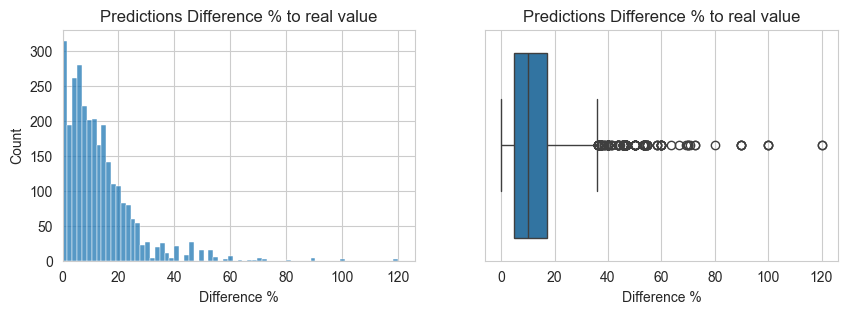

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 3))
sns.histplot(data = ComparationTable, x = 'Difference %', ax = ax1)
ax1.set_xlim(left = 0)
ax1.set_title('Predictions Difference % to real value')

sns.boxplot(data = ComparationTable, x = 'Difference %', ax = ax2)
ax2.set_title('Predictions Difference % to real value');

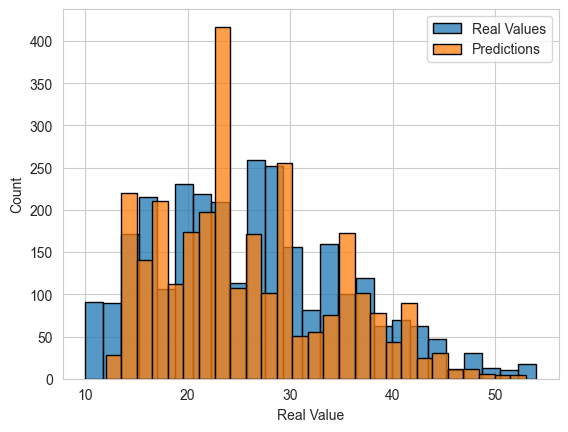

In [24]:
sns.histplot(data = ComparationTable, x = 'Real Value', label = 'Real Values', edgecolor = 'k')
sns.histplot(data = ComparationTable, x = 'Model Prediction', label = 'Predictions', edgecolor = 'k')
plt.legend();

/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_81636/2546632452.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = ComparationTable, x = 'Model Prediction', ax = ax1, edgecolor = 'k', palette = 'Blues')
/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_81636/2546632452.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = ComparationTable, x = 'Real Value', ax = ax2, edgecolor = 'k', palette = 'Purples')


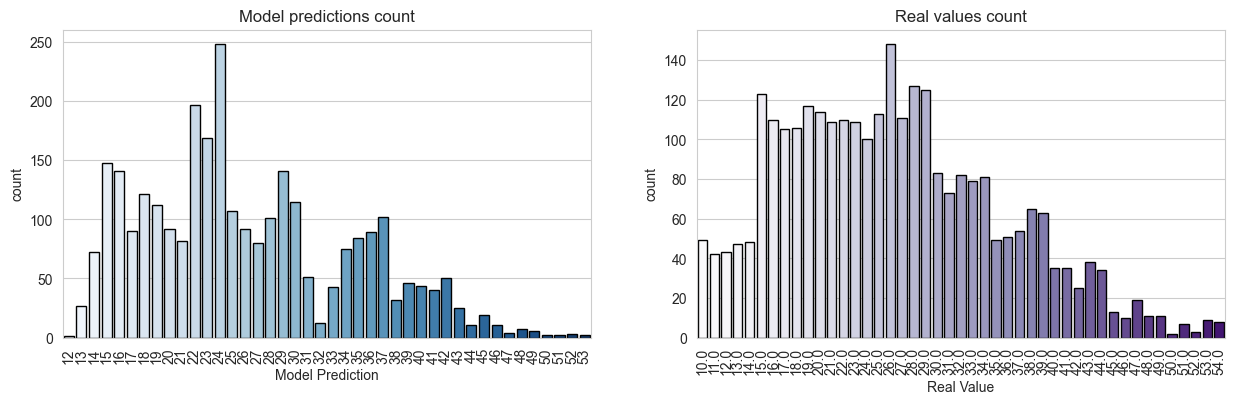

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1,figsize = (15, 4))
sns.countplot(data = ComparationTable, x = 'Model Prediction', ax = ax1, edgecolor = 'k', palette = 'Blues')
ax1.set_title('Model predictions count')
sns.countplot(data = ComparationTable, x = 'Real Value', ax = ax2, edgecolor = 'k', palette = 'Purples')
ax2.set_title('Real values count')

for ax in [ax1, ax2]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

/var/folders/m4/y98c53d15dg1mt8b2xxsb6s40000gn/T/ipykernel_81636/3414777646.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = ComparationTable, x = 'Difference', edgecolor = 'k', palette = 'Pastel1')


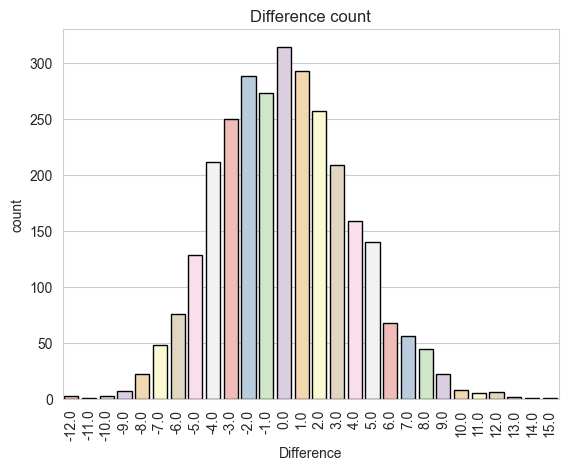

In [26]:
sns.countplot(data = ComparationTable, x = 'Difference', edgecolor = 'k', palette = 'Pastel1')
plt.xticks(rotation = 90)
plt.title('Difference count');

In [27]:
ComparationTable['Difference'].value_counts().to_frame().head(10)

,count
Difference,
0.0,314
1.0,293
-2.0,288
-1.0,273
2.0,257
-3.0,250
-4.0,211
3.0,209
4.0,159


In [28]:
## Saving the model weights
import pickle
with open("../models/gbm.pkl", "wb") as f:
    pickle.dump(gbm, f)

with open("../models/onehot_encoder", "wb") as f:
    pickle.dump(encoder, f)
with open("../models/scaler", "wb") as f:
    pickle.dump(scaler, f)

### Predictions at random

In [29]:
import random
index = random.randint(0, len(X_test))

ToPredict = X_test.iloc[[index]]
RealValue = y_test.iloc[[index]]
with open("../models/gbm.pkl", "rb") as f:
    model = pickle.load(f)

with open("../models/onehot_encoder", "rb") as f:
    encoder = pickle.load(f)

with open("../models/scaler", "rb") as f:
    scaler = pickle.load(f)


['Delivery_person_Age' 'Delivery_person_Ratings' 'Vehicle_condition'
 'multiple_deliveries' 'distance_rest_del_loc' 'hour' 'day'
 'Weatherconditions_conditions Cloudy' 'Weatherconditions_conditions Fog'
 'Weatherconditions_conditions Sandstorms'
 'Weatherconditions_conditions Stormy'
 'Weatherconditions_conditions Sunny' 'Weatherconditions_conditions Windy'
 'Road_traffic_density_High ' 'Road_traffic_density_Jam '
 'Road_traffic_density_Low ' 'Road_traffic_density_Medium '
 'Type_of_order_Buffet ' 'Type_of_order_Drinks ' 'Type_of_order_Meal '
 'Type_of_order_Snack ' 'Type_of_vehicle_electric_scooter '
 'Type_of_vehicle_motorcycle ' 'Type_of_vehicle_scooter ' 'Festival_No '
 'Festival_Yes ' 'City_Metropolitian ' 'City_Semi-Urban ' 'City_Urban '
 'weekday_name_Friday' 'weekday_name_Monday' 'weekday_name_Saturday'
 'weekday_name_Sunday' 'weekday_name_Thursday' 'weekday_name_Tuesday'
 'weekday_name_Wednesday' 'TypeOfMeal_Breakfast' 'TypeOfMeal_Dinner'
 'TypeOfMeal_Lunch']


In [ ]:
X_pre = data_preprocessing(ToPredict, train= False, encoder=encoder, scaler=scaler)
predicted_val = model.predict(X_pre)
predicted_val

In [ ]:
predicted_val[0],  RealValue.iloc[0]

In [30]:
# Create a DataFrame directly from the dictionary
single_row = pd.DataFrame({
    'Delivery_person_Age': [22],
    'Delivery_person_Ratings': [4.5],
    'Weatherconditions': ['conditions Cloudy'],
    'Road_traffic_density': ['Medium '],
    'Vehicle_condition': [0],
    'Type_of_order': ['Buffet '],
    'Type_of_vehicle': ['motorcycle '],
    'multiple_deliveries': [1],
    'Festival': ['No '],
    'City': ['Urban '],
    'distance_rest_del_loc': [2.851095],
    'hour': [17],
    'day': [11],
    'weekday_name': ['Friday'],
    'TypeOfMeal': ['Dinner']
})


# Convert single Series row to DataFrame
single_row_df = single_row
single_row_preprocessed = data_preprocessing(single_row_df, train= False, encoder= encoder, scaler = scaler)



In [31]:
prediction = model.predict(single_row_preprocessed)
prediction

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


array([22.9723565])

In [32]:
X_train.Road_traffic_density.unique()

array(['Low ', 'Medium ', 'High ', 'Jam '], dtype=object)

In [33]:
single_row_preprocessed

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,multiple_deliveries,distance_rest_del_loc,hour,day,Weatherconditions_conditions Cloudy,Weatherconditions_conditions Fog,Weatherconditions_conditions Sandstorms,Weatherconditions_conditions Stormy,Weatherconditions_conditions Sunny,Weatherconditions_conditions Windy,Road_traffic_density_High,Road_traffic_density_Jam,Road_traffic_density_Low,Road_traffic_density_Medium,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Festival_No,Festival_Yes,City_Metropolitian,City_Semi-Urban,City_Urban,weekday_name_Friday,weekday_name_Monday,weekday_name_Saturday,weekday_name_Sunday,weekday_name_Thursday,weekday_name_Tuesday,weekday_name_Wednesday,TypeOfMeal_Breakfast,TypeOfMeal_Dinner,TypeOfMeal_Lunch
0,-1.31591,-0.43437,-1.2237,0.440993,-0.918237,-0.085749,-0.325721,2.221761,-0.451878,-0.445829,-0.449315,-0.439752,-0.44638,-0.329419,-0.678169,-0.722703,1.760313,1.738956,-0.576813,-0.57848,-0.579051,-0.298119,0.843351,-0.70818,0.142672,-0.142672,-1.840888,-0.060745,1.860334,2.346057,-0.398855,-0.4024,-0.395441,-0.402448,-0.40197,-0.429789,-0.462766,0.605701,-0.318355
